# MiniBatchSparsePCA with  StandardScaler

This code template is for Mini-batch Sparse Principal Components Analysis in python for dimensionality reduction technique. It finds the set of sparse components that can optimally reconstruct the data. The amount of sparseness is controllable by the coefficient of the L1 penalty, given by the parameter alpha. The data is scaled by StandardScaler.

### Required Packages

In [1]:
import warnings 
import itertools
import numpy as np 
import pandas as pd 
import seaborn as se 
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.decomposition import MiniBatchSparsePCA
from numpy.linalg import eigh
warnings.filterwarnings('ignore')

### Initialization

Filepath of CSV file

In [2]:
#filepath
file_path= " "

List of features which are  required for model training .

In [3]:
#x_values
features=[]

Target feature for prediction.

In [4]:
#y_value
target=' '

### Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [5]:
df=pd.read_csv(file_path)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Feature Selections

It is the process of reducing the number of input variables when developing a predictive model. Used to reduce the number of input variables to both reduce the computational cost of modelling and, in some cases, to improve the performance of the model.

We will assign all the required input features to X and target/outcome to Y.

In [6]:
X = df[features]
Y = df[target]

### Data Preprocessing

Since the majority of the machine learning models in the Sklearn library doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippet have functions, which removes the null value if any exists. And convert the string classes data in the datasets by encoding them to integer classes.


In [7]:
def NullClearner(df):
    if(isinstance(df, pd.Series) and (df.dtype in ["float64","int64"])):
        df.fillna(df.mean(),inplace=True)
        return df
    elif(isinstance(df, pd.Series)):
        df.fillna(df.mode()[0],inplace=True)
        return df
    else:return df
def EncodeX(df):
    return pd.get_dummies(df)

In [8]:
x=X.columns.to_list()
for i in x:
    X[i]=NullClearner(X[i])  
X=EncodeX(X)
Y=NullClearner(Y)
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,0,1,0


#### Correlation Map

In order to check the correlation between the features, we will plot a correlation matrix. It is effective in summarizing a large amount of data where the goal is to see patterns.

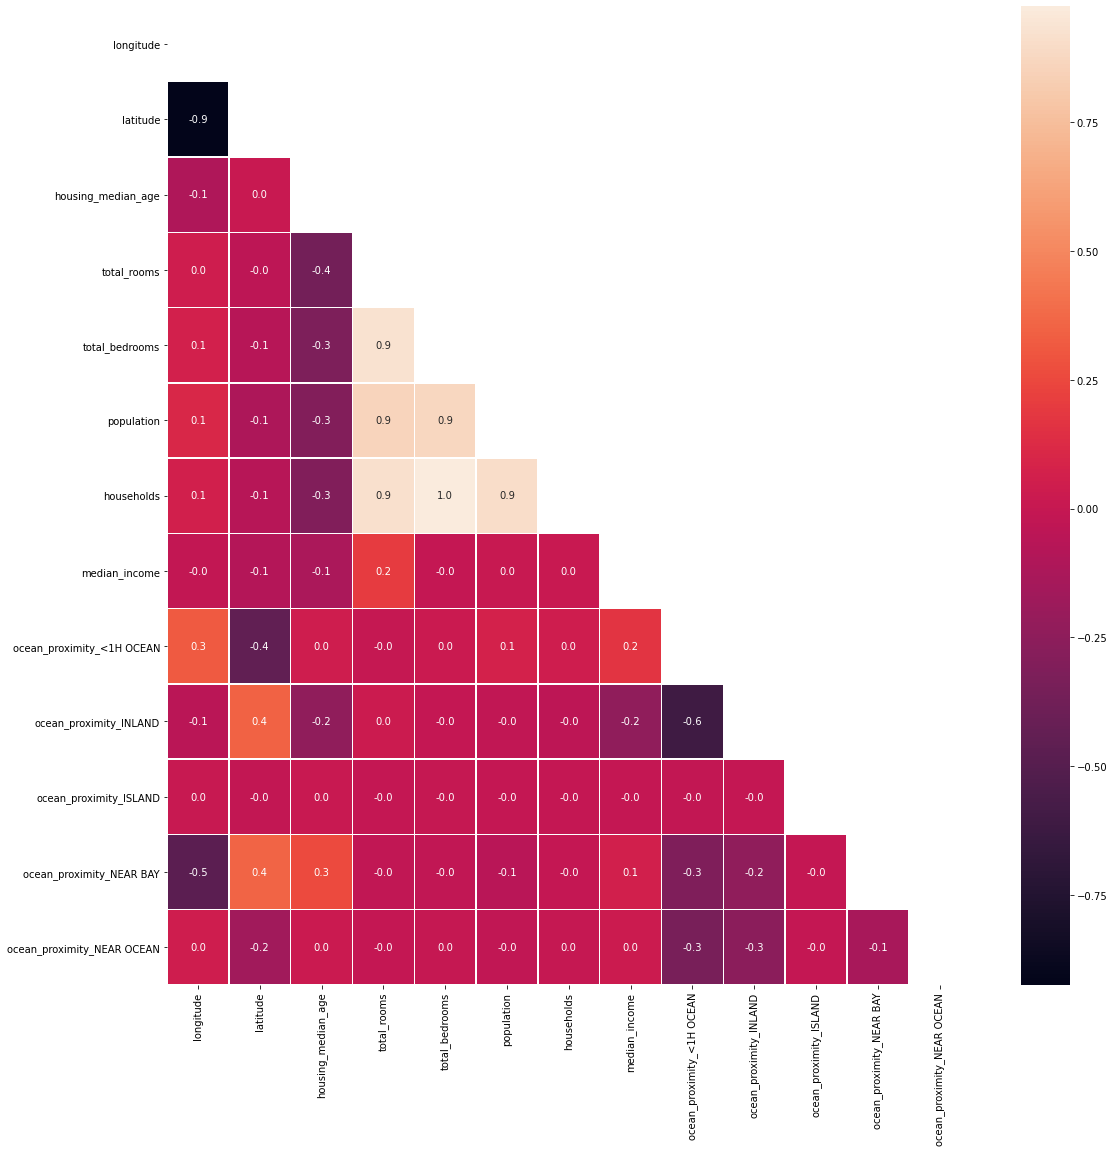

In [9]:
f,ax = plt.subplots(figsize=(18, 18))
matrix = np.triu(X.corr())
se.heatmap(X.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, mask=matrix)
plt.show()

### Data Rescaling

Performing StandardScaler data rescaling operation on dataset. The StandardScaler standardize features by removing the mean and scaling to unit variance.

[API](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [10]:
X_Scaled=StandardScaler().fit_transform(X)
X=pd.DataFrame(X_Scaled,columns=X.columns)
X.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-1.327835,1.052548,0.982143,-0.804819,-0.975228,-0.974429,-0.977033,2.344766,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
1,-1.322844,1.043185,-0.607019,2.045890,1.355088,0.861439,1.669961,2.332238,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
2,-1.332827,1.038503,1.856182,-0.535746,-0.829732,-0.820777,-0.843637,1.782699,-0.891156,-0.681889,-0.015566,2.830742,-0.384466


### Choosing the number of components

A vital part of using Mini-Batch Sparse PCA in practice is the ability to estimate how many components are needed to describe the data. This can be determined by looking at the cumulative explained variance ratio as a function of the number of components.

This curve quantifies how much of the total, dimensional variance is contained within the first N components. 

### Explained Variance

Explained variance refers to the variance explained by each of the principal components (eigenvectors). It can be represented as a function of ratio of related eigenvalue and sum of eigenvalues of all eigenvectors.

In [11]:
def explained_variance_plot(X):
    cov_matrix = np.cov(X, rowvar=False)
    egnvalues, egnvectors = eigh(cov_matrix)
    total_egnvalues = sum(egnvalues)
    var_exp = [(i/total_egnvalues) for i in sorted(egnvalues, reverse=True)]
    plt.plot(np.cumsum(var_exp))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    
    return var_exp

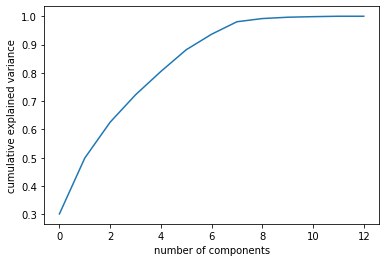

In [12]:
var_exp = explained_variance_plot(X)

#### Scree plot
The scree plot helps you to determine the optimal number of components. The eigenvalue of each component in the initial solution is plotted. Generally, you want to extract the components on the steep slope. The components on the shallow slope contribute little to the solution. 

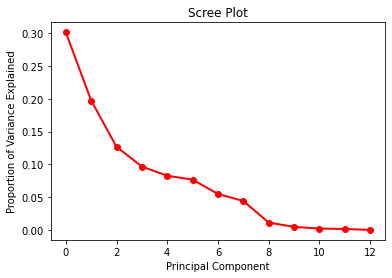

In [13]:
plt.plot(var_exp, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

### Model

Mini-batch Sparse Principal Components Analysis

Finds the set of sparse components that can optimally reconstruct the data. The amount of sparseness is controllable by the coefficient of the L1 penalty, given by the parameter alpha.

#### Model Tuning Parameters:

[API](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.MiniBatchSparsePCA.html)

    1. n_components: int, default=None
> number of sparse atoms to extract

    2. alpha: int, default=1
> Sparsity controlling parameter. Higher values lead to sparser components.

    3. ridge_alpha: float, default=0.01
> Amount of ridge shrinkage to apply in order to improve conditioning when calling the transform method.

    4. n_iter: int, default=100
> number of iterations to perform for each mini batch

    5. batch_size: int, default=3
> the number of features to take in each mini batch

    6. shuffle: bool, default=True
> whether to shuffle the data before splitting it in batches

    7. method: {‘lars’, ‘cd’}, default=’lars’
> lars: uses the least angle regression method to solve the lasso problem (linear_model.lars_path) cd: uses the coordinate descent method to compute the Lasso solution (linear_model.Lasso). Lars will be faster if the estimated components are sparse.

    8. random_state: int, RandomState instance or None, default=None
> Used for random shuffling when shuffle is set to True, during online dictionary learning. Pass an int for reproducible results across multiple function calls.

In [14]:
mbspca = MiniBatchSparsePCA(n_components=3)
pcaX = pd.DataFrame(data = mbspca.fit_transform(X))

#### Output Dataframe

In [15]:
finalDf = pd.concat([pcaX, Y], axis = 1)
finalDf.head()

,0,1,2,median_house_value
0,-1.639555,-0.712039,-3.460076,452600.0
1,3.073790,0.601767,-3.462185,358500.0
2,-1.471478,-0.765147,-3.640225,352100.0
3,-1.484858,-0.559977,-3.543989,341300.0
4,-1.417940,-0.311306,-3.443646,342200.0


#### Creator: Viraj Jayant, Github: [Profile](https://github.com/Viraj-Jayant)